In [1]:
#imports
import pandas as pd
import json
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
# Load sleep data
sleep_data = pd.read_csv('sleep-data.csv', delimiter=';')

# Convert datetime columns to proper datetime objects
sleep_data['Went to bed'] = pd.to_datetime(sleep_data['Went to bed'])
sleep_data['Woke up'] = pd.to_datetime(sleep_data['Woke up'])

# Load watch history JSON
with open('watch-history.json', 'r', encoding='utf-8') as f:
    watch_history = json.load(f)

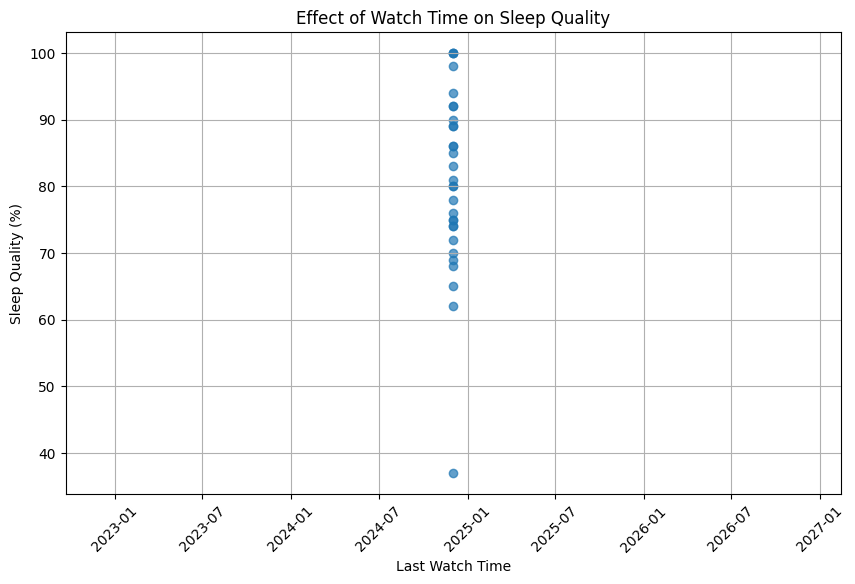

In [5]:
# Parse watch history into a DataFrame
watch_history_data = []
for entry in watch_history:
    try:
        watch_time = datetime.strptime(entry['time'], '%Y-%m-%dT%H:%M:%S.%fZ')
    except ValueError:
        try:
            watch_time = datetime.strptime(entry['time'], '%Y-%m-%dT%H:%M:%SZ')
        except ValueError:
            print(f"Unrecognized time format: {entry['time']}")
            continue
    title = entry['title']
    platform = entry['header']
    watch_history_data.append({'Time': watch_time, 'Title': title, 'Platform': platform})

watch_df = pd.DataFrame(watch_history_data)

# Merge datasets
# Find the closest watch time before sleep
merged_data = []
for index, row in sleep_data.iterrows():
    sleep_start = row['Went to bed']
    relevant_watches = watch_df[watch_df['Time'] < sleep_start]
    if not relevant_watches.empty:
        last_watch = relevant_watches.iloc[-1]
        merged_data.append({
            'Sleep Start': sleep_start,
            'Sleep Quality': row['Sleep Quality'],
            'Time in bed (seconds)': row['Time in bed (seconds)'],
            'Time asleep (seconds)': row['Time asleep (seconds)'],
            'Last Watch Time': last_watch['Time'],
            'Last Watch Title': last_watch['Title'],
            'Platform': last_watch['Platform']
        })

merged_df = pd.DataFrame(merged_data)

# Convert Sleep Quality to numeric for analysis
merged_df['Sleep Quality'] = merged_df['Sleep Quality'].str.rstrip('%').astype(float)

# Visualization: Scatter plot of watch time vs. sleep quality
plt.figure(figsize=(10, 6))
plt.scatter(merged_df['Last Watch Time'], merged_df['Sleep Quality'], alpha=0.7)
plt.xlabel('Last Watch Time')
plt.ylabel('Sleep Quality (%)')
plt.title('Effect of Watch Time on Sleep Quality')
plt.xticks(rotation=45)
plt.grid()
plt.show()

## Step